# IoT - Human Detection Notebook 📹

Giovanni Baccichet (`10851745`) - Politecnico di Milano

## Libraries 📔

In [123]:
import pandas as pd 
import glob
import matplotlib.pyplot as plt
import numpy as np
from numpy import array
import seaborn as sns
from datetime import datetime
import time
import os

In [124]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import completeness_score, homogeneity_score, v_measure_score

import pickle

## Pre-Processing 🧼

Setting working directory to current one.

In [125]:
working_directory = os.getcwd()
path = working_directory + '/Dataset/'

Reading dataset (CSV), setting the columns and converting the Time column to `datetime` type.

In [126]:
df = pd.read_csv('Dataset/zoom2_dataset.csv', encoding = "utf-8", index_col=False, on_bad_lines='skip')
df.columns=["Time", "Source", "Destination", "Protocol", "Length"]

df['Time'] = pd.to_datetime(df['Time'])


Adding the `Direction` column, depending on the `Source` IP address: if it is the eavedropper's one, then it is `Outboud`.

In [127]:
df['Direction'] = np.where(df['Source']== '192.168.178.69', 'Outbound', 'Inbound')

Visualizing the data frame.

In [128]:
df

,Time,Source,Destination,Protocol,Length,Direction
0,2022-06-29 11:56:16.424537,149.137.12.48,192.168.178.69,17,294,Inbound
1,2022-06-29 11:56:16.445008,149.137.12.48,192.168.178.69,17,415,Inbound
2,2022-06-29 11:56:16.486022,149.137.12.48,192.168.178.69,17,679,Inbound
3,2022-06-29 11:56:16.526955,149.137.12.48,192.168.178.69,17,595,Inbound
4,2022-06-29 11:56:16.526958,149.137.12.48,192.168.178.69,17,594,Inbound
...,...,...,...,...,...,...
193648,2022-06-29 12:36:05.084564,149.137.12.48,192.168.178.69,17,477,Inbound
193649,2022-06-29 12:36:05.084565,149.137.12.48,192.168.178.69,17,477,Inbound
193650,2022-06-29 12:36:05.084792,149.137.12.48,192.168.178.69,17,476,Inbound
193651,2022-06-29 12:36:05.084793,149.137.12.48,192.168.178.69,17,508,Inbound


Preparing the acquired **ground truth**: timestamps (acquired from the Node-RED exported CSV) need to be converted properly in order to be comparable with the data frame's ones.

In [129]:
present = datetime.fromtimestamp(1655546177926/1000).time()
end_present = datetime.fromtimestamp(1655547371263/1000).time()
end = datetime.fromtimestamp(1655548551788/1000).time()

print("Beginning of the acquisition process: ", present)
print("Person exists the frame: ", end_present)
print("End of the acquisition process: ", end)

Beginning of the acquisition process:  11:56:17.926000
Person exists the frame:  12:16:11.263000
End of the acquisition process:  12:35:51.788000


### Re-sampling Data Frame ✂️

Adding the ground truth to the data frame, based on previously acquired timestamps.

In [130]:
result = df.loc[df['Time'].dt.time.between(present, end_present), 'Person'] = 1

result = df.loc[df['Time'].dt.time.between(end_present, end), 'Person'] = 0

Removing rows before and after the acquisition process (since un-labelled).

In [131]:
df.dropna(subset = ["Person"], inplace=True)

Here the data frame is resampled every `FREQ` (100ms-900ms), grouping packets and extracting useful features per sample.

In [132]:
FREQ = '450ms'

df = df.set_index('Time')

Generating new features from re-sampled groups 🎁

In [133]:
df_resampled = df.groupby(pd.Grouper(freq=FREQ)).first()

In [134]:
df_resampled['PacketNumber'] = df.groupby(pd.Grouper(freq=FREQ))['Source'].count()

df_resampled['PacketIntervalAvg'] = 450/df_resampled['PacketNumber']

df_resampled['PacketSizeAvg'] = df.groupby(pd.Grouper(freq=FREQ))['Length'].mean()

df_resampled['PacketSizeStd'] = df.groupby(pd.Grouper(freq=FREQ))['Length'].std()

df_resampled['PacketSizeMed'] = df.groupby(pd.Grouper(freq=FREQ))['Length'].median()

df_resampled['PacketSizeMin'] = df.groupby(pd.Grouper(freq=FREQ))['Length'].min()

df_resampled['PacketSizeMax'] = df.groupby(pd.Grouper(freq=FREQ))['Length'].max()

df_resampled['InboundCount'] = df.groupby(pd.Grouper(freq=FREQ))['Direction'].apply(lambda x: (x=='Inbound').sum())

df_resampled['OutboundCount'] = df.groupby(pd.Grouper(freq=FREQ))['Direction'].apply(lambda x: (x=='Outbound').sum())

# df_resampled['InOutBoundRate'] = df_resampled['InboundCount']/df_resampled['OutboundCount']

In [135]:
df_resampled

,Source,Destination,Protocol,Length,Direction,Person,PacketNumber,PacketIntervalAvg,PacketSizeAvg,PacketSizeStd,PacketSizeMed,PacketSizeMin,PacketSizeMax,InboundCount,OutboundCount
Time,,,,,,,,,,,,,,,
2022-06-29 11:56:17.700,149.137.12.48,192.168.178.69,17.0,1238.0,Inbound,1.0,52,8.653846,928.480769,346.259536,1008.0,66.0,1270.0,48,4
2022-06-29 11:56:18.150,149.137.12.48,192.168.178.69,6.0,66.0,Inbound,1.0,70,6.428571,990.585714,358.566530,1088.5,66.0,1321.0,65,5
2022-06-29 11:56:18.600,149.137.12.48,192.168.178.69,17.0,1088.0,Inbound,1.0,50,9.000000,957.440000,413.806430,1122.0,66.0,1287.0,45,5
2022-06-29 11:56:19.050,149.137.12.48,192.168.178.69,17.0,1087.0,Inbound,1.0,80,5.625000,892.975000,383.245995,1010.0,123.0,1296.0,73,7
2022-06-29 11:56:19.500,149.137.12.48,192.168.178.69,17.0,1217.0,Inbound,1.0,28,16.071429,1010.571429,215.669059,1061.0,120.0,1249.0,27,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-29 12:35:49.650,149.137.12.48,192.168.178.69,17.0,284.0,Inbound,0.0,27,16.666667,535.333333,236.563701,523.0,94.0,1162.0,26,1
2022-06-29 12:35:50.100,149.137.12.48,192.168.178.69,17.0,704.0,Inbound,0.0,26,17.307692,603.115385,310.082225,496.5,117.0,1143.0,24,2
2022-06-29 12:35:50.550,149.137.12.48,192.168.178.69,17.0,787.0,Inbound,0.0,63,7.142857,1180.444444,214.563381,1260.0,116.0,1333.0,62,1


Removing old columns, that make no sense after the re-sampling.

In [136]:
df_resampled.drop('Source',axis = 1,inplace= True)

df_resampled.drop('Destination',axis = 1,inplace= True)

df_resampled.drop('Protocol',axis = 1,inplace= True)

df_resampled.drop('Length',axis = 1,inplace= True)

df_resampled.drop('Direction',axis = 1,inplace= True)

Removing NaN values from data frame.

In [137]:
df_resampled = df_resampled.dropna()
df_resampled

,Person,PacketNumber,PacketIntervalAvg,PacketSizeAvg,PacketSizeStd,PacketSizeMed,PacketSizeMin,PacketSizeMax,InboundCount,OutboundCount
Time,,,,,,,,,,
2022-06-29 11:56:17.700,1.0,52,8.653846,928.480769,346.259536,1008.0,66.0,1270.0,48,4
2022-06-29 11:56:18.150,1.0,70,6.428571,990.585714,358.566530,1088.5,66.0,1321.0,65,5
2022-06-29 11:56:18.600,1.0,50,9.000000,957.440000,413.806430,1122.0,66.0,1287.0,45,5
2022-06-29 11:56:19.050,1.0,80,5.625000,892.975000,383.245995,1010.0,123.0,1296.0,73,7
2022-06-29 11:56:19.500,1.0,28,16.071429,1010.571429,215.669059,1061.0,120.0,1249.0,27,1
...,...,...,...,...,...,...,...,...,...,...
2022-06-29 12:35:49.650,0.0,27,16.666667,535.333333,236.563701,523.0,94.0,1162.0,26,1
2022-06-29 12:35:50.100,0.0,26,17.307692,603.115385,310.082225,496.5,117.0,1143.0,24,2
2022-06-29 12:35:50.550,0.0,63,7.142857,1180.444444,214.563381,1260.0,116.0,1333.0,62,1


## Data Frame Visualization 📊

Print statistics about each row.

In [138]:
df_resampled.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Person,5233.0,0.505255,0.500020,0.000000,0.000000,1.000000,1.000000,1.000000
PacketNumber,5233.0,36.650869,24.966878,2.000000,15.000000,29.000000,56.000000,202.000000
PacketIntervalAvg,5233.0,21.121746,23.119388,2.227723,8.035714,15.517241,30.000000,225.000000
PacketSizeAvg,5233.0,590.936446,423.388374,88.500000,169.066667,471.136364,1045.125000,1240.000000
PacketSizeStd,5233.0,155.874179,135.077832,0.000000,32.587890,140.917873,247.752622,564.140183
PacketSizeMed,5233.0,626.331836,459.542151,88.500000,169.500000,474.000000,1117.500000,1271.000000
PacketSizeMin,5233.0,113.889165,101.579923,66.000000,66.000000,116.000000,118.000000,1195.000000
PacketSizeMax,5233.0,772.421556,511.996002,111.000000,215.000000,939.000000,1289.000000,1339.000000
InboundCount,5233.0,33.816358,24.450758,2.000000,14.000000,23.000000,54.000000,196.000000
OutboundCount,5233.0,2.834512,2.865442,0.000000,1.000000,1.000000,4.000000,18.000000


List the columns we can plot.

In [139]:
print(df_resampled.columns.tolist())

['Person', 'PacketNumber', 'PacketIntervalAvg', 'PacketSizeAvg', 'PacketSizeStd', 'PacketSizeMed', 'PacketSizeMin', 'PacketSizeMax', 'InboundCount', 'OutboundCount']


Visualization of the number of packages per sample, along with the ground truth.

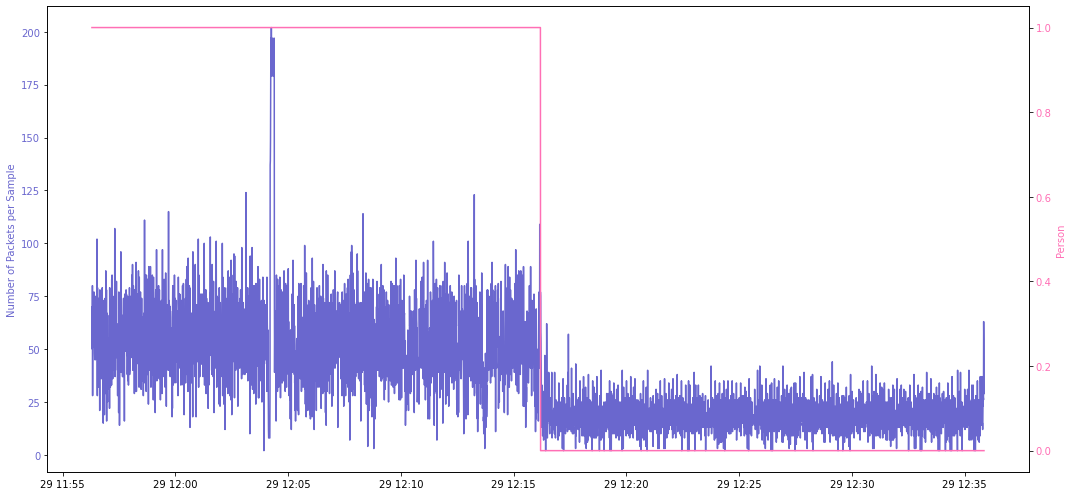

In [140]:
fig, ax1 = plt.subplots(figsize=(15,7))

color = '#6A67CE'
ax1.set_ylabel('Number of Packets per Sample', color=color)
ax1.plot(df_resampled['PacketNumber'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = '#FF6FB5'
ax2.set_ylabel('Person', color=color)  # we already handled the x-label with ax1
ax2.plot(df_resampled['Person'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Graphical Visualization of average time between packets over time.

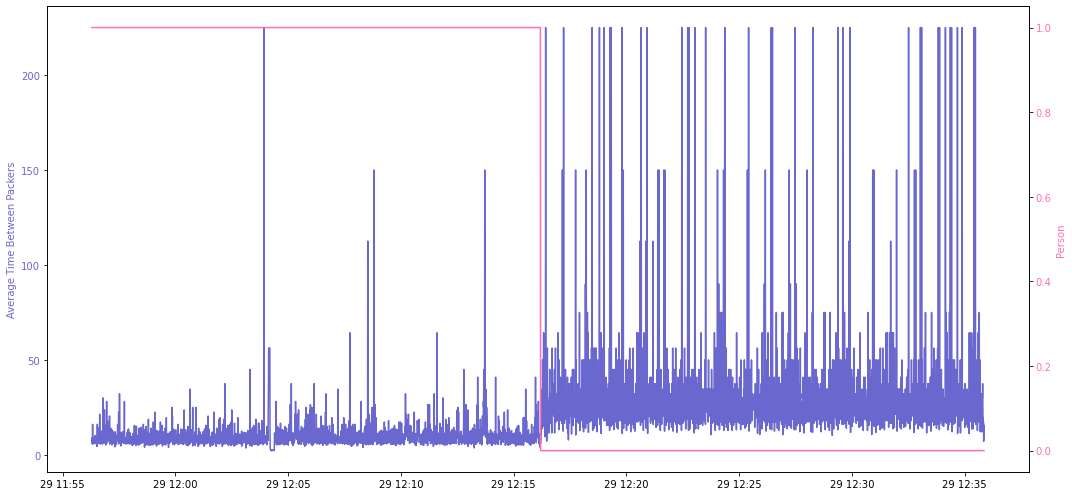

In [141]:
fig, ax1 = plt.subplots(figsize=(15,7))

color = '#6A67CE'
ax1.set_ylabel('Average Time Between Packers', color=color)
ax1.plot(df_resampled['PacketIntervalAvg'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = '#FF6FB5'
ax2.set_ylabel('Person', color=color)  # we already handled the x-label with ax1
ax2.plot(df_resampled['Person'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Plot the average packet size per sample, over time.

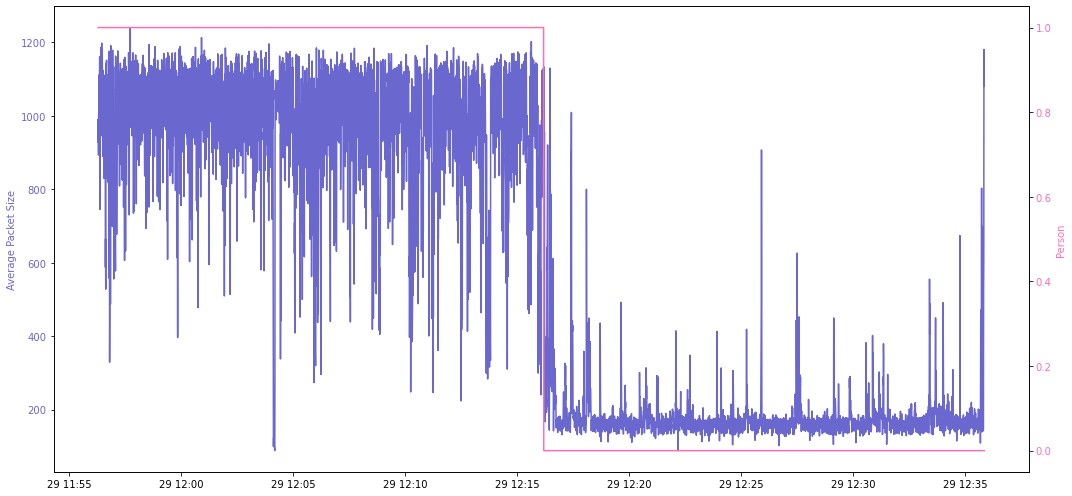

In [142]:
fig, ax1 = plt.subplots(figsize=(15,7))

color = '#6A67CE'
ax1.set_ylabel('Average Packet Size', color=color)
ax1.plot(df_resampled['PacketSizeAvg'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = '#FF6FB5'
ax2.set_ylabel('Person', color=color)  # we already handled the x-label with ax1
ax2.plot(df_resampled['Person'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Plot the comparison between outbound traffic and inbound traffic over time.

<AxesSubplot:xlabel='Time'>

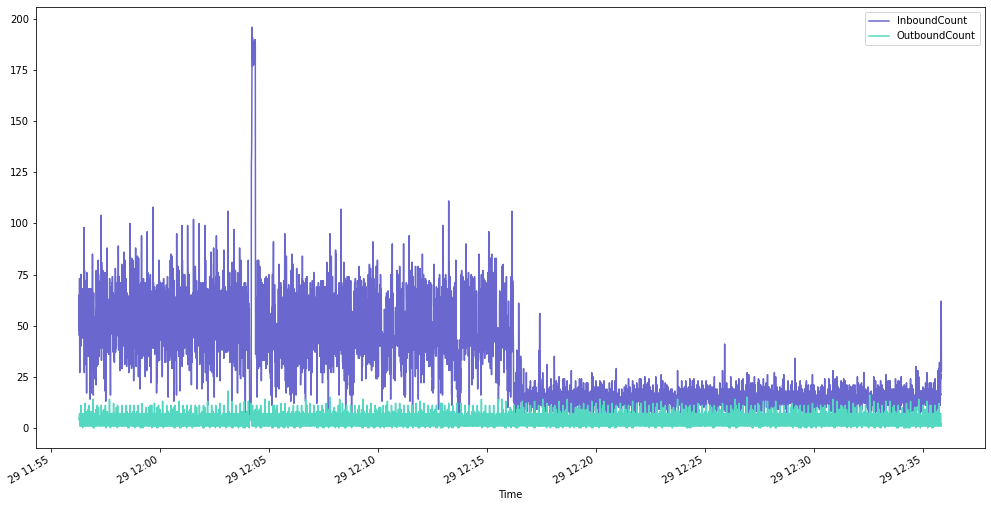

In [143]:
ax = df_resampled.plot(y='InboundCount', figsize=(17,9), color='#6A67CE')

df_resampled.plot(y='OutboundCount', color='#55D8C1', ax=ax)

Visualization of the difference between inbound traffic with and without the target in frame.

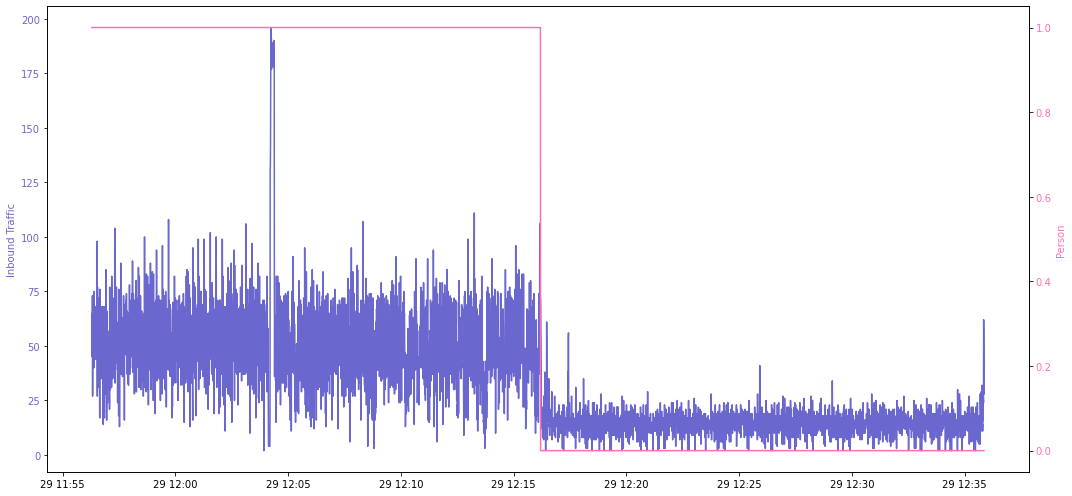

In [144]:
fig, ax1 = plt.subplots(figsize=(15,7))

color = '#6A67CE'
ax1.set_ylabel('Inbound Traffic', color=color)
ax1.plot(df_resampled['InboundCount'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = '#FF6FB5'
ax2.set_ylabel('Person', color=color)  # we already handled the x-label with ax1
ax2.plot(df_resampled['Person'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Visualizing different features in one single place, along with the ground truth.

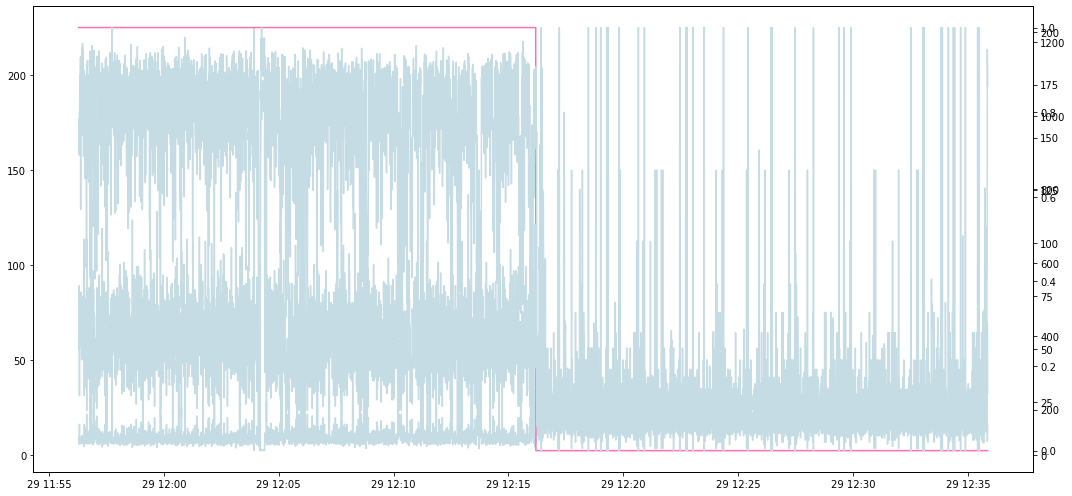

In [145]:
fig, ax1 = plt.subplots(figsize=(15,7))

color = '#C6DCE4'
ax1.plot(df_resampled['PacketIntervalAvg'], color=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = '#FF6FB5'
ax2.plot(df_resampled['Person'], color=color)

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = '#C6DCE4'
ax3.plot(df_resampled['PacketSizeAvg'], color=color)

ax4 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = '#C6DCE4'
ax4.plot(df_resampled['PacketNumber'], color=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Data Frame Splitting 🔪

Splitting the data frame is necessary to test the model accuracy.

In [146]:
X = df_resampled.drop('Person', axis=1)
Y = df_resampled['Person']

x_train, x_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.4, stratify=Y)
x_test, x_validate, y_test, y_validate = train_test_split(x_temp, y_temp, test_size=0.5, stratify=y_temp)

### Data Frame Normalization 🚸

In [147]:
df_resampled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5233 entries, 2022-06-29 11:56:17.700000 to 2022-06-29 12:35:51.450000
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Person             5233 non-null   float64
 1   PacketNumber       5233 non-null   int64  
 2   PacketIntervalAvg  5233 non-null   float64
 3   PacketSizeAvg      5233 non-null   float64
 4   PacketSizeStd      5233 non-null   float64
 5   PacketSizeMed      5233 non-null   float64
 6   PacketSizeMin      5233 non-null   float64
 7   PacketSizeMax      5233 non-null   float64
 8   InboundCount       5233 non-null   int64  
 9   OutboundCount      5233 non-null   int64  
dtypes: float64(7), int64(3)
memory usage: 449.7 KB


In [148]:
# Replacing Inf values with NaN
df_resampled = df_resampled.replace([np.inf, -np.inf], np.nan)

# Dropping all occurrences of NaN
df_resampled = df_resampled.dropna()

Normalize the data frame's values

In [149]:
# Normalize
min_max_scaler = MinMaxScaler().fit(x_train)

# Apply normalization to dataset
x_train = min_max_scaler.transform(x_train)
x_validate = min_max_scaler.transform(x_validate)
x_test = min_max_scaler.transform(x_test)

# All values between 0 and 1
pd.Series(x_train.flatten()).describe()

count    28251.000000
mean         0.262596
std          0.309706
min          0.000000
25%          0.056701
50%          0.091000
75%          0.341411
max          1.000000
dtype: float64

## Feature Selection 🏆

Print the correlation matrix in order to visualize if the selected features are highly correlated (if so we should drop the related columns).

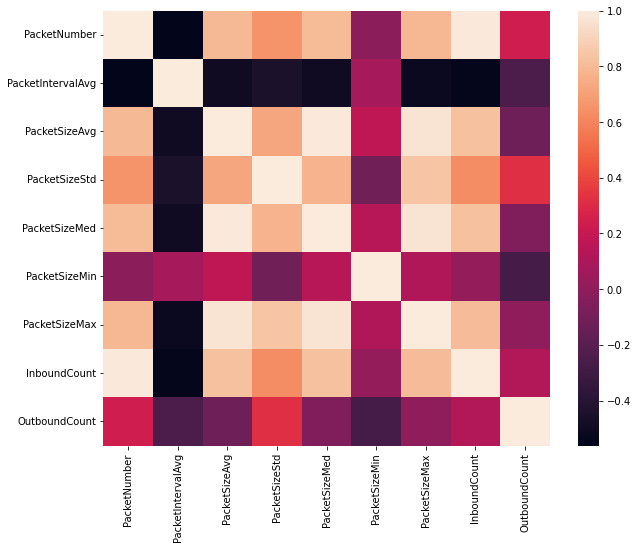

In [150]:
features = df_resampled
features.drop('Person',axis = 1,inplace= True)

corr = features.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr)
plt.show()

## Training and Testing 🥊

### Random Forest 🌲

Select *Random Forest* as classifier.

In [151]:
classifier =  RandomForestClassifier()

**Training** the model.

In [152]:
start = time.time()
classifier.fit(x_train, y_train)
end = time.time()
training_time = end - start

**Testing** the model.

In [153]:
start = time.time()
y_predicted = classifier.predict(x_validate)
end = time.time()
predict_time = end  - start
print(training_time, predict_time)

0.32010531425476074 0.01903080940246582


Print the **confusion matrix** of the just trained model.

Some statistics about the accuracy of the model.

In [154]:
precision, recall, fscore, support = score(y_validate, y_predicted)
d = {'Precision': precision, 'Recall' : recall, 'FScore': fscore}
results = pd.DataFrame(data=d)
results

,Precision,Recall,FScore
0,0.980583,0.974903,0.977735
1,0.975564,0.981096,0.978322


#### Estimator Optimization

In [155]:
# n estimators is the number of decision trees we consider in the ensemble 
n_estimators = [12, 25, 50, 100, 200, 400, 800, 1600]
results = []
time_results = []

In [156]:
# note: takes a long time
for estimator in n_estimators: 
    # fit model with n_estimators parameter
    classifier =  RandomForestClassifier(n_estimators=estimator)
    classifier.fit(x_train, y_train)
    
    # predict validation
    start = time.time()
    y_pred = classifier.predict(x_validate)
    end = time.time()
    
    # calculate metrics
    p, r, f1, n = score(y_validate, y_pred, average = 'macro')
    
    # append f1 and time to results array
    results.append(f1)
    time_results.append(end-start)

Text(0.5, 1.0, 'How n_estimators value changes classification time')

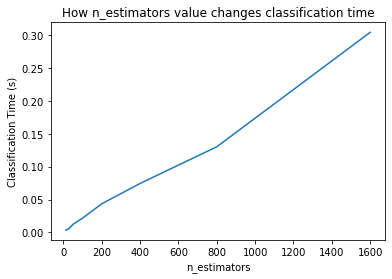

In [157]:
# plot classification time for n_estimators
plt.plot(n_estimators, time_results)
plt.xlabel('n_estimators')
plt.ylabel('Classification Time (s)')
plt.title('How n_estimators value changes classification time')

Text(0.5, 1.0, 'How n_estimators value changes F1 score for the validation dataset')

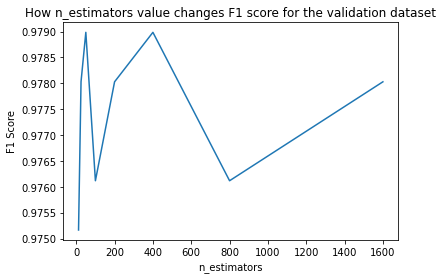

In [158]:
# plot f1 score for n estimators
plt.plot(n_estimators, results)
plt.xlabel('n_estimators')
plt.ylabel('F1 Score')
plt.title('How n_estimators value changes F1 score for the validation dataset')

In [159]:
from sklearn.model_selection import RandomizedSearchCV

max_features = [int(x) for x in np.linspace(2, 40, num = 20)] # from 2 to 40 (max number) of features (up in 2s)
max_features.append('auto') 
max_depth = [int(x) for x in np.linspace(10, 200, num = 10)] # 10 values for max depth from 10 to 200
max_depth.append(None) # also have option for no max depth
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': [25], # chosen n_estimator
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [160]:
# Use the random grid to search for best hyperparameters

rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=178, max_features=10, min_samples_leaf=2, min_samples_split=10, n_estimators=25; total time=   0.0s
[CV] END bootstrap=True, max_depth=115, max_features=6, min_samples_leaf=4, min_samples_split=2, n_estimators=25; total time=   0.2s
[CV] END bootstrap=True, max_depth=115, max_features=6, min_samples_leaf=4, min_samples_split=2, n_estimators=25; total time=   0.2s
[CV] END bootstrap=True, max_depth=178, max_features=10, min_samples_leaf=2, min_samples_split=10, n_estimators=25; total time=   0.0s
[CV] END bootstrap=True, max_depth=115, max_features=6, min_samples_leaf=4, min_samples_split=2, n_estimators=25; total time=   0.2s
[CV] END bootstrap=True, max_depth=178, max_features=10, min_samples_leaf=2, min_samples_split=10, n_estimators=25; total time=   0.0s
[CV] END bootstrap=True, max_depth=157, max_features=22, min_samples_leaf=2, min_samples_split=5, n_estimators=25; total time=   0.0s

/Users/bacci/opt/anaconda3/envs/IoT-HumanDetection/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
231 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/bacci/opt/anaconda3/envs/IoT-HumanDetection/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/bacci/opt/anaconda3/envs/IoT-HumanDetection/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/Users/bacci/opt/anaconda3/envs/IoT-HumanDetection/lib/python3.9/site-p

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 31, 52, 73, 94, 115,
                                                      136, 157, 178, 200,
                                                      None],
                                        'max_features': [2, 4, 6, 8, 10, 12, 14,
                                                         16, 18, 20, 22, 24, 26,
                                                         28, 30, 32, 34, 36, 38,
                                                         40, 'auto'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [25]},
                   random_state=42, verbose=2)

In [161]:
rf_random.best_params_

{'n_estimators': 25,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 2,
 'max_depth': 157,
 'bootstrap': True}

In [162]:
classifier =  RandomForestClassifier(n_estimators=25, 
                                     max_depth=115, 
                                     min_samples_split=2, 
                                     min_samples_leaf=4, 
                                     max_features=6, 
                                     bootstrap=True
)
# fit 
start = time.time()
classifier.fit(x_train, y_train)
end = time.time()
training_time = end - start

# predict
start = time.time()
y_predicted = classifier.predict(x_validate)
end = time.time()
predict_time = end  - start
print(training_time, predict_time)

0.14557790756225586 0.0047512054443359375


In [163]:
precision, recall, fscore, support = score(y_validate, y_predicted)
d = {'Precision': precision, 'Recall' : recall, 'FScore': fscore}
results = pd.DataFrame(data=d)
results

,Precision,Recall,FScore
0,0.984375,0.972973,0.978641
1,0.973832,0.984877,0.979323


### K-Nearest Neighbor 🚪

Selecting *KNN* as classifier and starting the training.

In [164]:
classifier = KNeighborsClassifier(n_neighbors=100)
classifier.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=100)

In [165]:
y_pred = classifier.predict(x_test)

In [166]:
precision, recall, fscore, support = score(y_test, y_pred)
d = {'Precision': precision, 'Recall' : recall, 'FScore': fscore}
results = pd.DataFrame(data=d)
results

,Precision,Recall,FScore
0,0.986328,0.974903,0.980583
1,0.975701,0.986767,0.981203


In [167]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[505  13]
 [  7 522]]
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       518
         1.0       0.98      0.99      0.98       529

    accuracy                           0.98      1047
   macro avg       0.98      0.98      0.98      1047
weighted avg       0.98      0.98      0.98      1047



### Support Vector Machine 🤖

In [168]:
svclassifier = SVC(kernel='linear')
svclassifier.fit(x_train, y_train)

SVC(kernel='linear')

In [169]:
svclassifier = SVC(kernel='linear')
svclassifier.fit(x_train, y_train)

SVC(kernel='linear')

In [170]:
y_pred = svclassifier.predict(x_test)

In [171]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[508  10]
 [  5 524]]
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99       518
         1.0       0.98      0.99      0.99       529

    accuracy                           0.99      1047
   macro avg       0.99      0.99      0.99      1047
weighted avg       0.99      0.99      0.99      1047



### Logistic Regression 🐵

In [172]:
logreg = LogisticRegression()

logreg.fit(x_train,y_train)

y_pred=logreg.predict(x_test)

In [173]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[510,   8],
       [  8, 521]])

In [174]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[510   8]
 [  8 521]]
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       518
         1.0       0.98      0.98      0.98       529

    accuracy                           0.98      1047
   macro avg       0.98      0.98      0.98      1047
weighted avg       0.98      0.98      0.98      1047

